In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
import os
import pathlib
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d
from statsbombpy import sb

# pd.options.mode.chained_assignment = None
# warnings.filterwarnings('ignore')

In [ ]:
# list of callable functions
functions = [func for func in dir(sb) if callable(getattr(sb, func))]
functions

['Pool',
 'Union',
 '_360_frames',
 'competition_events',
 'competition_frames',
 'competitions',
 'events',
 'filter_and_group_events',
 'frames',
 'lineups',
 'matches',
 'merge_events_and_frames',
 'partial',
 'player_match_stats',
 'player_season_stats',
 'reduce_events',
 'team_season_stats']

In [ ]:
comps = sb.competitions()
serieA_matches = sb.matches(competition_id=12, season_id=27)

team_name = 'Inter Milan'
team = serieA_matches[(serieA_matches['home_team'] == team_name) | (serieA_matches['away_team'] == team_name)]


In [ ]:
team_matchids = team['match_id']

team_events = pd.DataFrame()
for match in team_matchids:
    
    serieA_events = sb.events(match_id=match)

    # if it's the first match, initiate the empty dataframe
    if (match==team_matchids.iloc[0]):
        team_events = serieA_events
        
    else:
        team_events = pd.concat([team_events, serieA_events])

In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(team_events):
    # filter on only ball moving variables (dribble, pass, carry)
    # team_events = team_events[(team_events['type'].str.contains("Pass", regex=False, na=False)) | (team_events['type'] == "Dribble") | (team_events['type'].str.contains("Carry", regex=False, na=False))]
    
    # don't include dribble for now as there is no end location data
    team_events = team_events[(team_events['type'].str.contains("Pass", regex=False, na=False)) | (team_events['type'].str.contains("Carry", regex=False, na=False))]
    
    # filter on only successful passes
    team_events = team_events[team_events['pass_outcome'].isna()]
    # separate x and y coordinates
    team_events["x"] = team_events.location.apply(lambda cell: (cell[0]))
    team_events["y"] = team_events.location.apply(lambda cell: (cell[1]))

    
    team_events["pass_end_x"] = team_events.pass_end_location.apply(lambda cell: (cell[0]) if isinstance(cell, (list, tuple)) else None)
    team_events["pass_end_y"] = team_events.pass_end_location.apply(lambda cell: (cell[1]) if isinstance(cell, (list, tuple)) else None) 

    team_events["carry_end_x"] = team_events.carry_end_location.apply(lambda cell: (cell[0]) if isinstance(cell, (list, tuple)) else None)
    team_events["carry_end_y"] = team_events.carry_end_location.apply(lambda cell: (cell[1]) if isinstance(cell, (list, tuple)) else None)


    return team_events

team_events_clean = clean_data(team_events.copy())
team_events_clean.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,foul_committed_penalty,foul_won_penalty,goalkeeper_shot_saved_off_target,shot_saved_off_target,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,60.0,40.0,59.7,40.1,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,60.9,38.4,45.5,38.4,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,41.2,34.8,35.1,66.7,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,92.7,70.1,85.1,69.8,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,85.1,68.4,93.1,61.2,NaN,NaN


In [ ]:
team_events_clean[['player', 'type', 'location', 'x', 'y', 'pass_end_location', 'pass_end_x', 'pass_end_y', 'carry_end_location', 'carry_end_x', 'carry_end_y']]
team_events_clean.type.unique()

array(['Pass', 'Carry'], dtype=object)

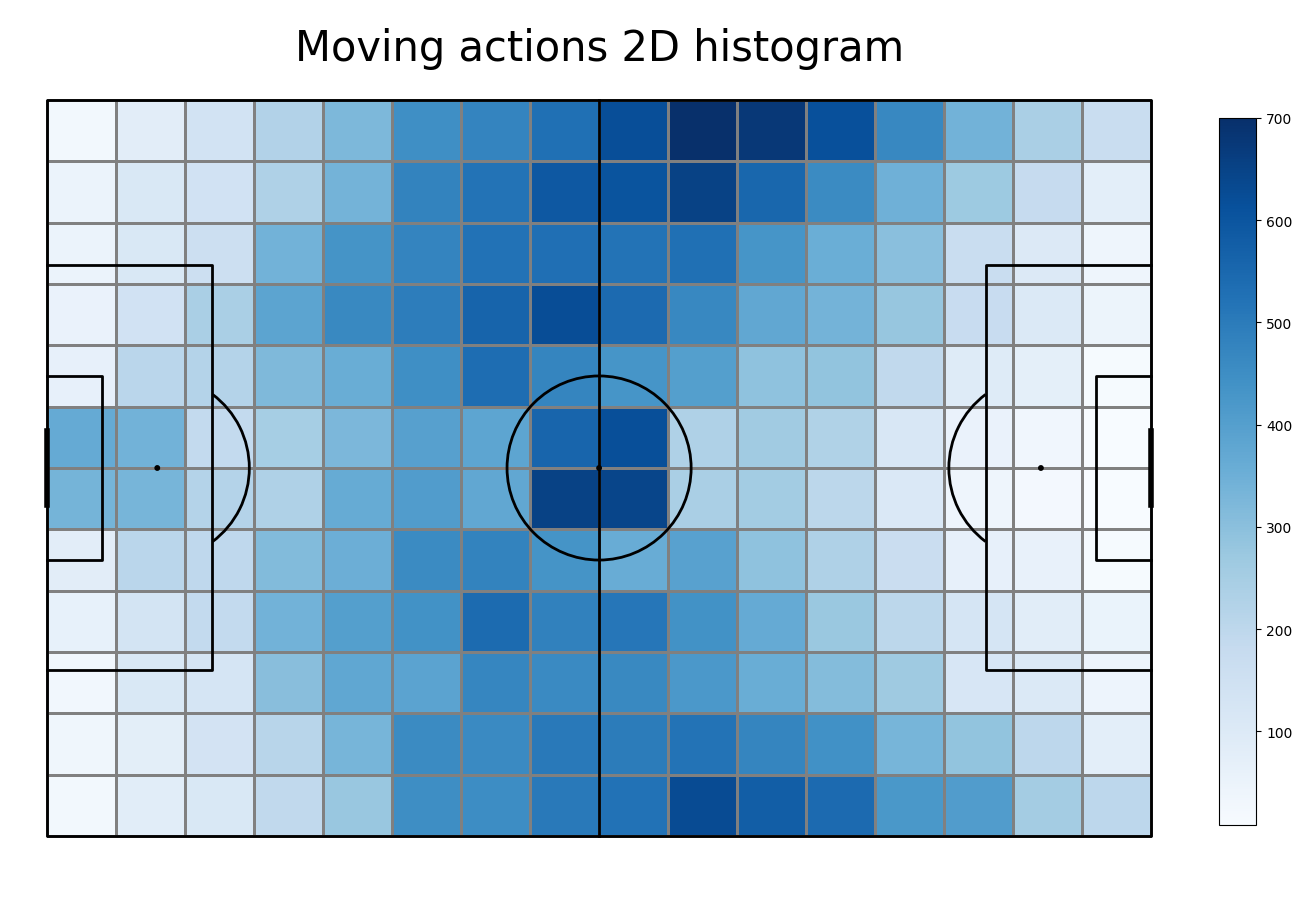

In [ ]:
#create 2D histogram to show where most actions (passes or carries) took place
pitch = Pitch(line_color='black', pitch_type='statsbomb', line_zorder = 2)
move = pitch.bin_statistic(team_events_clean.x, team_events_clean.y, statistic='count', bins=(16, 12), normalize=False) # separate pitch into these bins and visualise counts of moves

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]


In [ ]:
# get the shot data
def shot_data(team_data):
    shot_df = team_data[team_data['type']=='Shot']
    # separate x and y coordinates
    shot_df["x"] = shot_df.location.apply(lambda cell: (cell[0]))
    shot_df["y"] = shot_df.location.apply(lambda cell: (cell[1]))

    return shot_df

shot_df = shot_data(team_events.copy())
shot_df[['player', 'location', 'x', 'y', 'shot_outcome']]

C:\Users\GEdwards\AppData\Local\Temp\ipykernel_138476\2893542754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df["x"] = shot_df.location.apply(lambda cell: (cell[0]))
C:\Users\GEdwards\AppData\Local\Temp\ipykernel_138476\2893542754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_df["y"] = shot_df.location.apply(lambda cell: (cell[1]))


,player,location,x,y,shot_outcome
3793,Mauro Emanuel Icardi Rivero,"[110.5, 39.9]",110.5,39.9,Goal
3794,Marek Hamšík,"[89.5, 36.2]",89.5,36.2,Saved
3795,Lorenzo Insigne,"[86.8, 41.8]",86.8,41.8,Off T
3796,Allan Marques Loureiro,"[87.4, 41.2]",87.4,41.2,Saved
3797,Ivan Strinić,"[93.8, 29.6]",93.8,29.6,Blocked
...,...,...,...,...,...
3555,Anderson Hernanes de Carvalho Andrade,"[110.3, 54.1]",110.3,54.1,Saved
3556,Rodrigo Sebastián Palacio,"[117.1, 33.8]",117.1,33.8,Post
3557,Anderson Hernanes de Carvalho Andrade,"[93.5, 50.7]",93.5,50.7,Saved
3558,Davide Santon,"[90.7, 49.8]",90.7,49.8,Saved


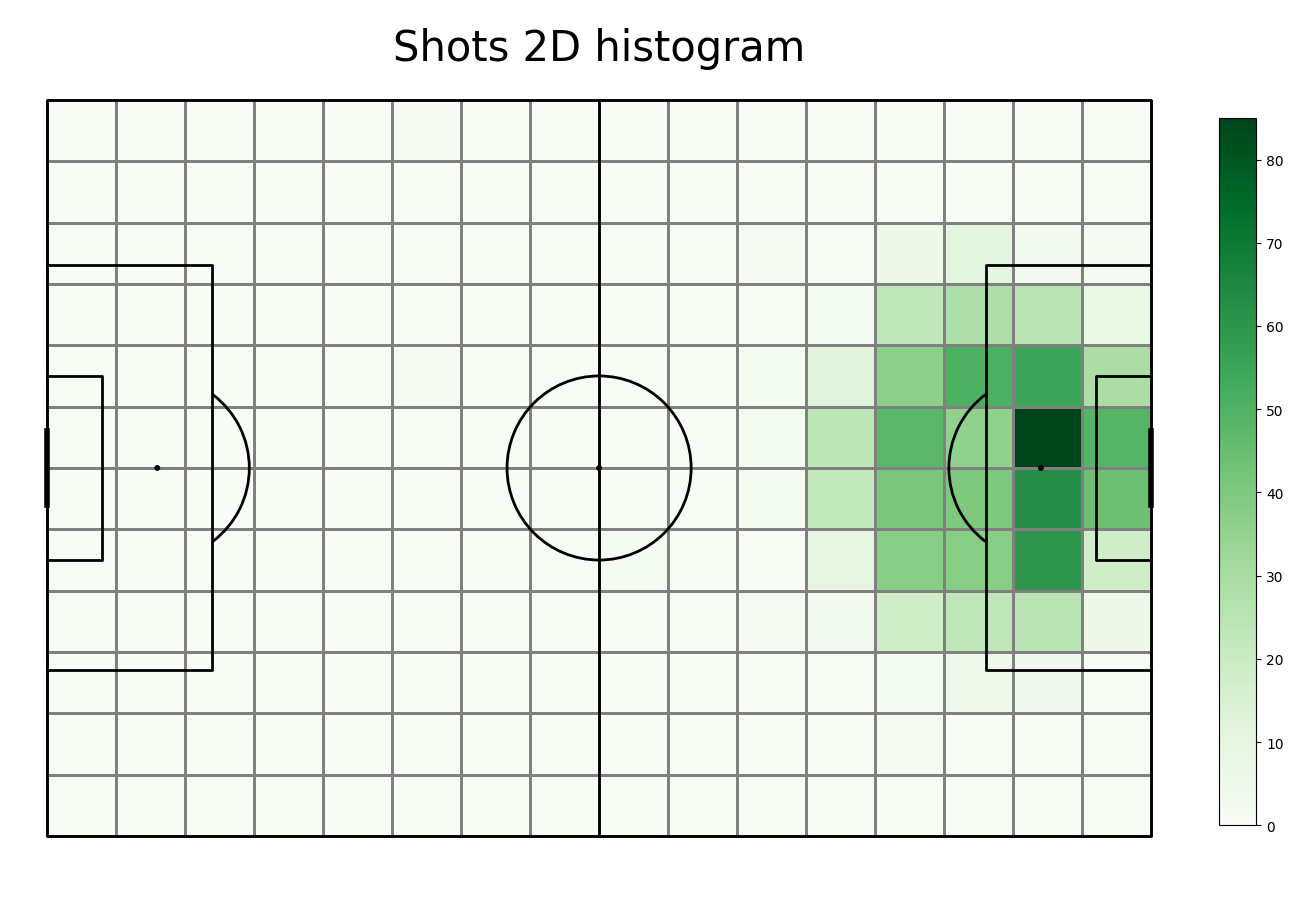

In [ ]:
# shot frequency per pitch zone plot

pitch = Pitch(line_color='black', pitch_type='statsbomb', line_zorder = 2)
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False) # separate pitch into these bins and visualise counts of shots

# plot heatmap of where shots come from based on shot count
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

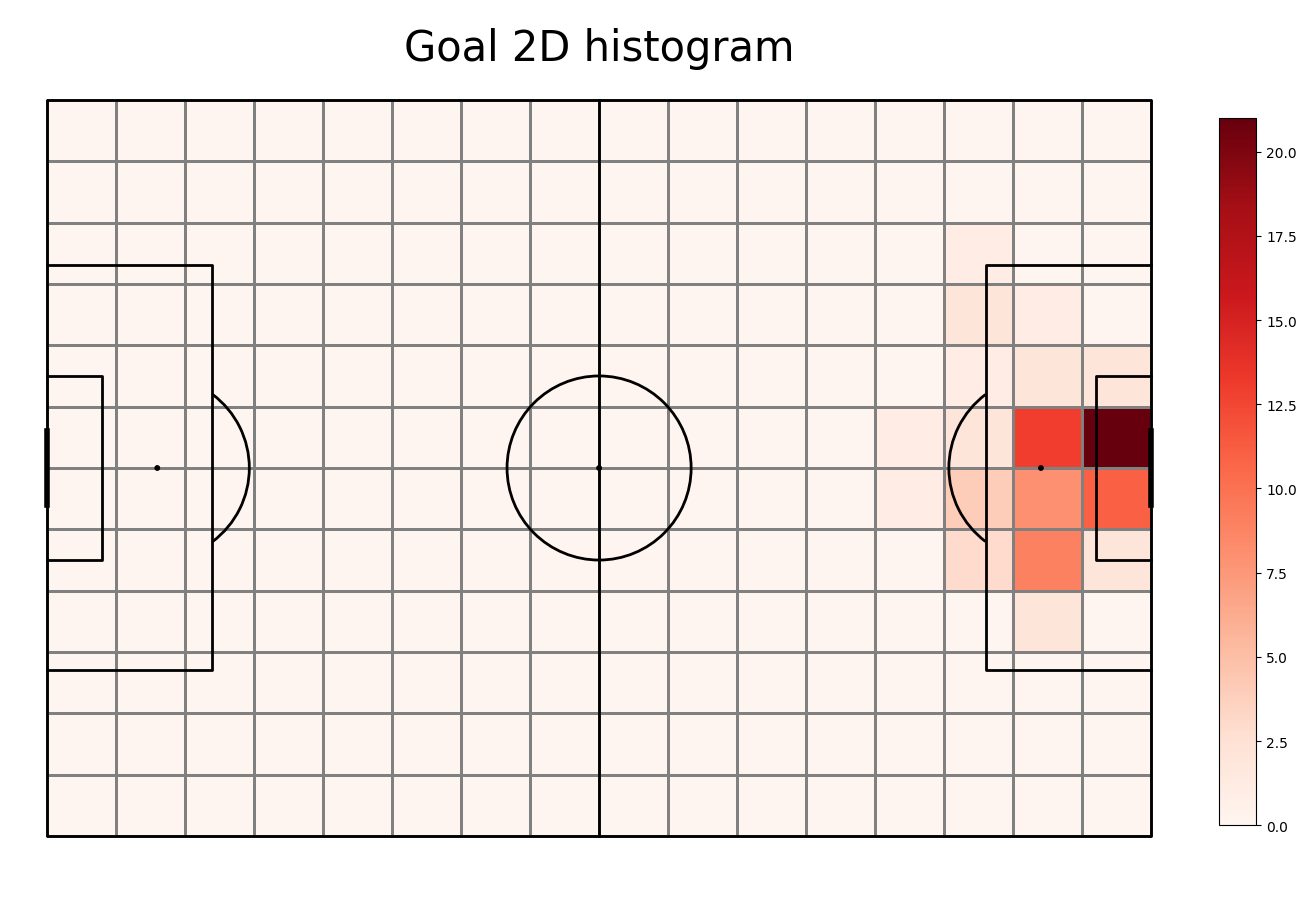

In [ ]:
# plot of goal frequency per segment
goal_df  = shot_df.loc[shot_df.apply(lambda x: 'Goal' in x.shot_outcome, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

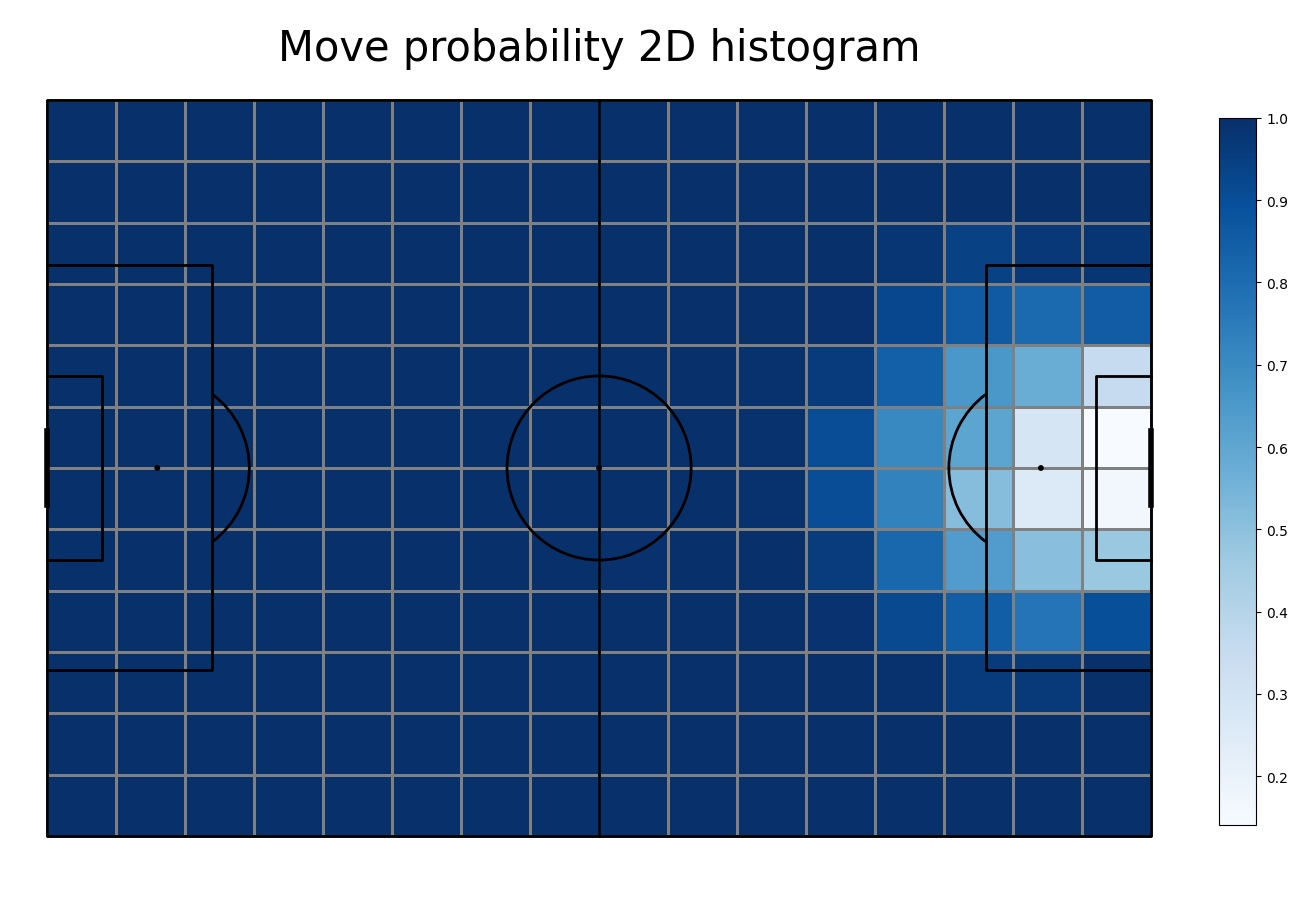

In [ ]:
# visualising the move probability
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

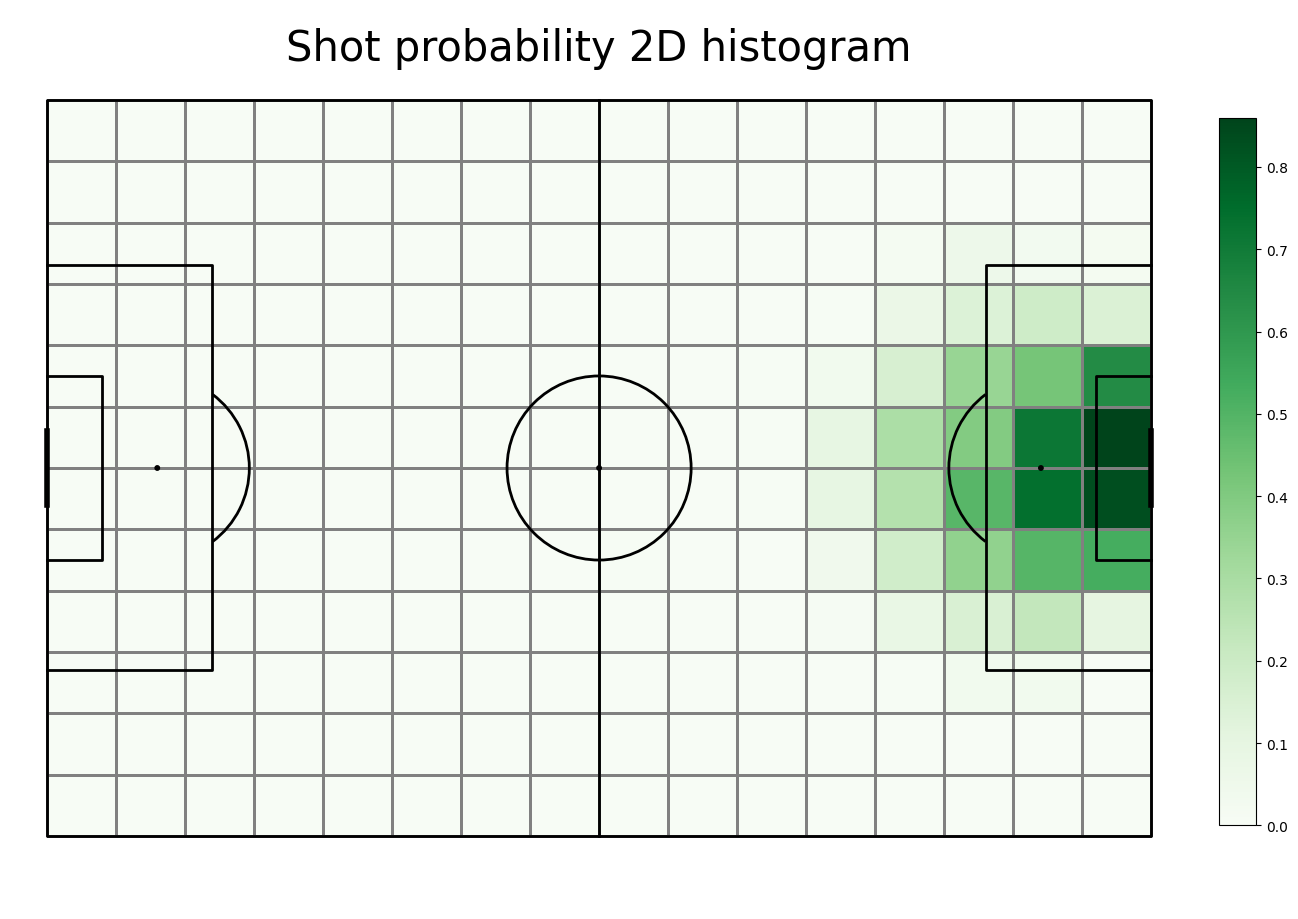

In [ ]:
# shot probability visualisation
shot_probability = shot_count/(move_count+shot_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()



C:\Users\GEdwards\AppData\Local\Temp\ipykernel_138476\1550068430.py:3: RuntimeWarning: invalid value encountered in divide
  goal_probability = goal_count / shot_count


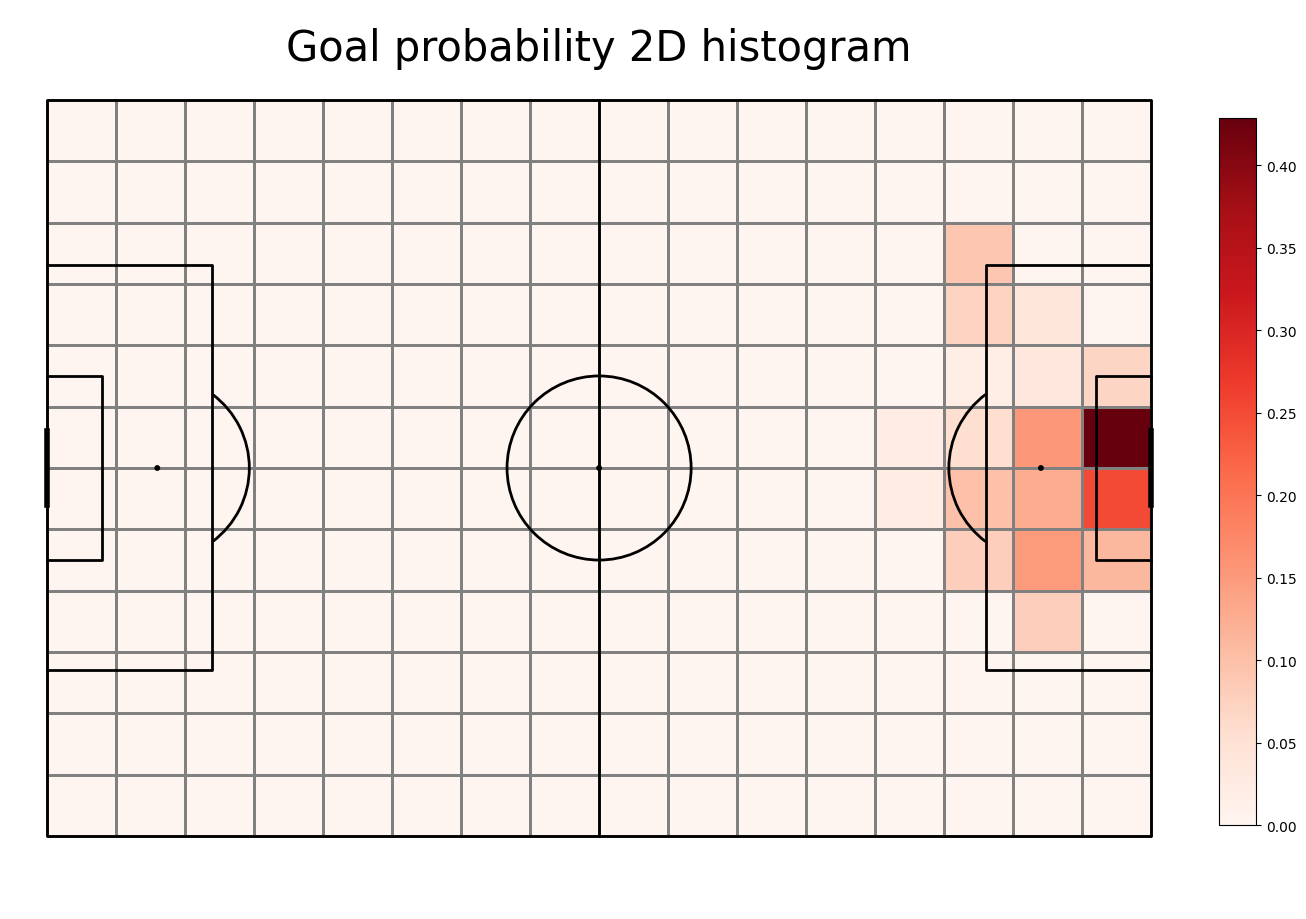

In [ ]:
# goal probability

goal_probability = goal_count / shot_count
goal_probability[np.isnan(goal_probability)] = 0

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

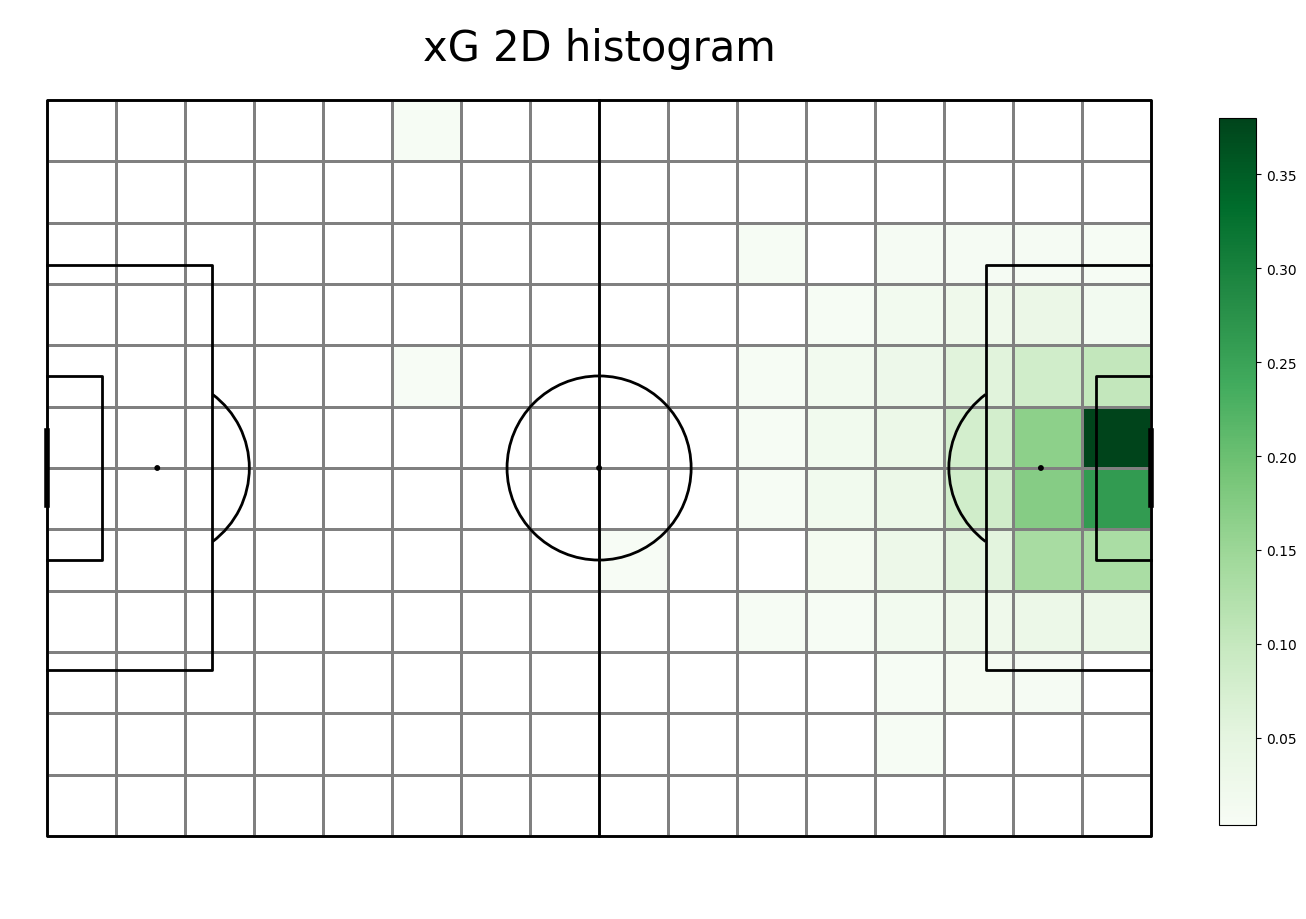

In [ ]:
# create plot where you visualise average xG in each block
pitch = Pitch(line_color='black', pitch_type='statsbomb', line_zorder = 2)
shot_xg = pitch.bin_statistic(shot_df.x, shot_df.y, values=shot_df.shot_statsbomb_xg, statistic='mean', bins=(16, 12), normalize=False)

# plot heatmap of where shots come from based on shot count
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot_xg, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('xG 2D histogram', fontsize = 30)
plt.show()

shot_xg_grid = shot_xg["statistic"]
shot_xg_grid[np.isnan(shot_xg_grid)] = 0

#### Transition Matrix

For each of 192 sectors we need to calculate a transition matrix - a matrix of probabilities going from one zone to another one given that the ball was moved. First, we create another columns in the move_df with the bin on the histogram that the event started and ended in. Then, we group the data by starting sector and count starts from each of them. As the next step, for each of the sectors we calculate the probability of transfering the ball from it to all 192 sectors on the pitch. given that the ball was moved. We do it as the division of events that went to the end sector by all events that started in the starting sector. As the last step, we vizualize the transition matrix for the sector in the bottom left corner of the pitch.

In [ ]:
# create move probability plot for each segment of the pitch (edit to use plotly and try a dynamic visualisation)

# Helper function to get the value if not NA, otherwise the alternative
def get_value_or_alternative(primary, alternative):
    return primary if not np.isnan(primary).all() else alternative

#### NB fill in missing sectors from start_sector. Some teams have had no action in specific sectors

#move start index - using the same function as mplsoccer, it should work
team_events_clean["start_sector"] = team_events_clean.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 120], [0, 80]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

all_sectors = [(i+1, j+1) for i in range(16) for j in range(12)]
current_sectors = team_events_clean['start_sector']
missing_sectors = set(all_sectors) - set(current_sectors)

for i in list(missing_sectors):
    team_events_clean = pd.concat([team_events_clean, pd.DataFrame({"start_sector":[i]})], ignore_index=True)


#move end index
team_events_clean["end_sector"] = team_events_clean.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(get_value_or_alternative(np.ravel(row.pass_end_x), np.ravel(row.carry_end_x)),
                                                                                                               get_value_or_alternative(np.ravel(row.pass_end_y), np.ravel(row.carry_end_y)),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 120], [0, 80]],
                                                               expand_binnumbers=True)[3]]), axis = 1) # produces bin (17,13) if pass_end and carry_end are nas this is due to no end value for dribbles


#df with summed events from each index
df_count_starts = team_events_clean.groupby(["start_sector"])["index"].count().reset_index() # number of actions that took place in each sector
df_count_starts.rename(columns = {'index':'count_starts'}, inplace=True)
print(df_count_starts)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    this_sector = team_events_clean.loc[team_events_clean["start_sector"] == start_sector]
    print(start_sector[0])

    if (this_sector.start_sector.values[0] not in list(missing_sectors)):
        if (start_sector[0] != 17):
            df_cound_ends = this_sector.groupby(["end_sector"])["index"].count().reset_index()
            df_cound_ends.rename(columns = {'index':'count_ends'}, inplace=True)
            # print(row)
            # print(df_cound_ends)
            T_matrix = np.zeros((12, 16))
            for j, row2 in df_cound_ends.iterrows():
                
                end_sector = row2["end_sector"]
                value = row2["count_ends"]

                # T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value

                # some rows still result in (17,13)
                T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value

            T_matrix = T_matrix / count_starts
            transition_matrices.append(T_matrix)
        
    else:
        T_matrix = np.zeros((12, 16))
        transition_matrices.append(T_matrix)

len(transition_matrices)

    start_sector  count_starts
0         (1, 1)            26
1         (1, 2)            51
2         (1, 3)            48
3         (1, 4)            57
4         (1, 5)            66
..           ...           ...
187      (16, 8)            16
188      (16, 9)            52
189     (16, 10)            45
190     (16, 11)            76
191     (16, 12)           202

[192 rows x 2 columns]
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16


192

In [ ]:
transition_matrices[191]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0049505 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.0049505 , 0.        , 0.00990099,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.0049505 , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0049505 ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 

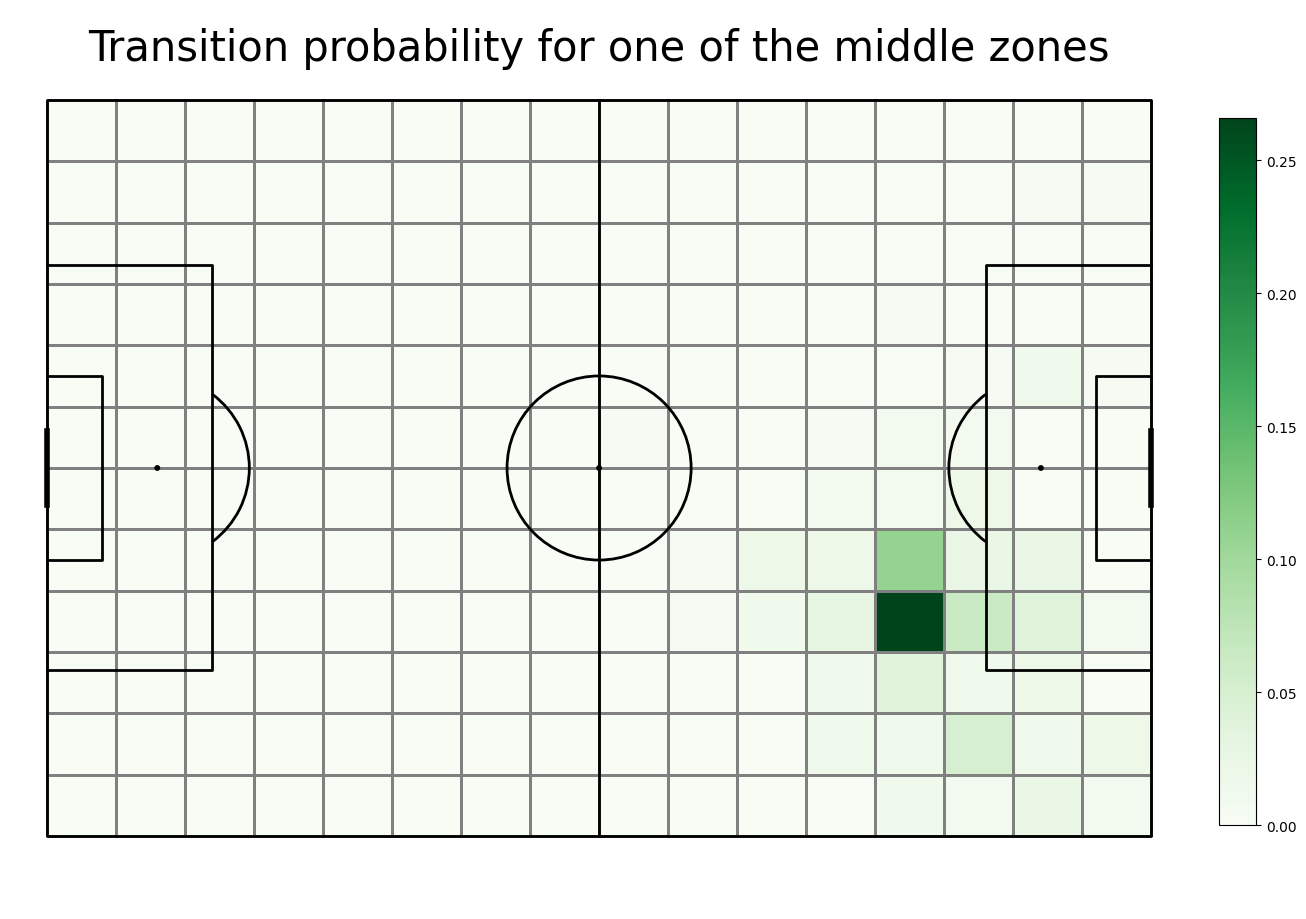

In [ ]:
#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Change the index here to change the zone.
goal["statistic"] = transition_matrices[152]
pcm  = pitch.heatmap(goal, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

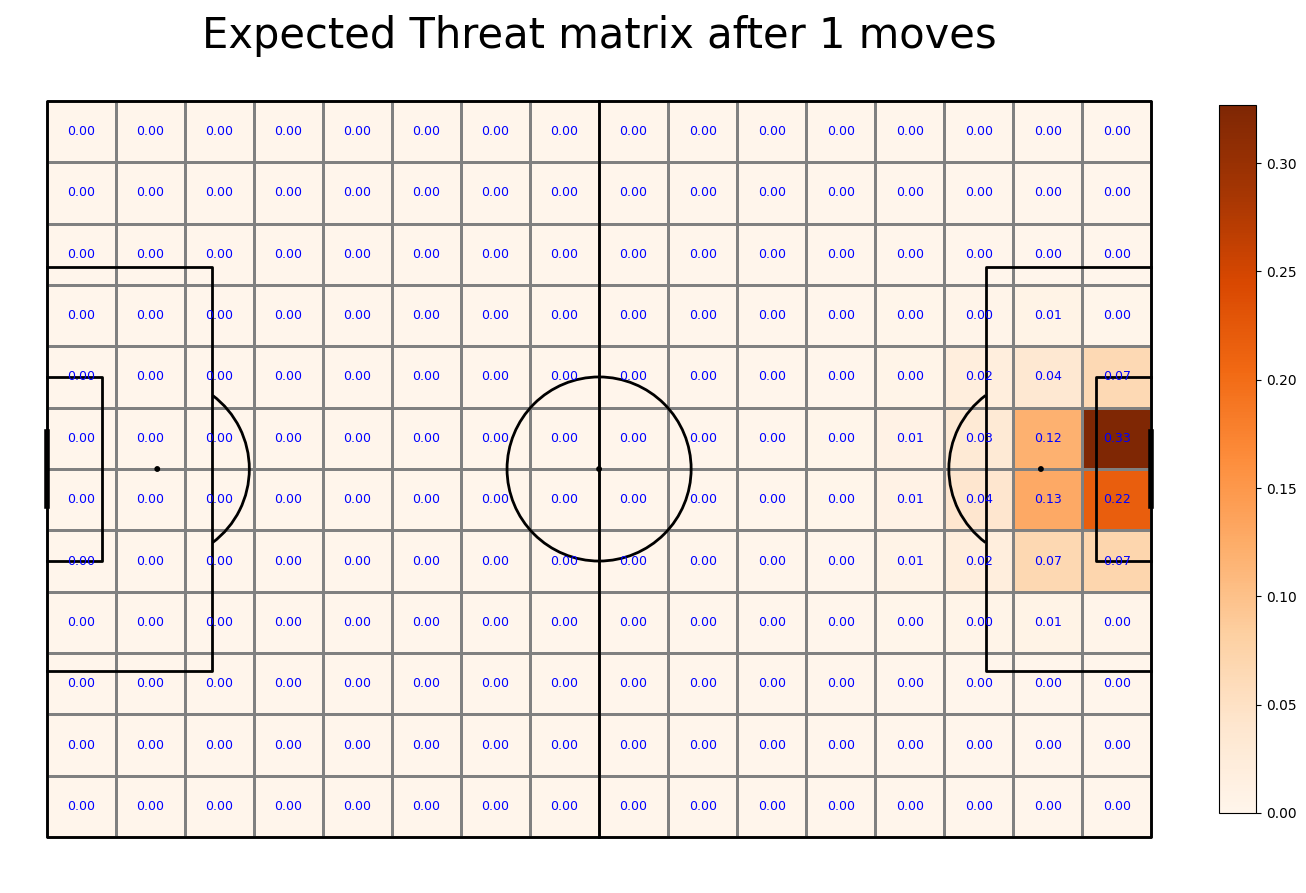

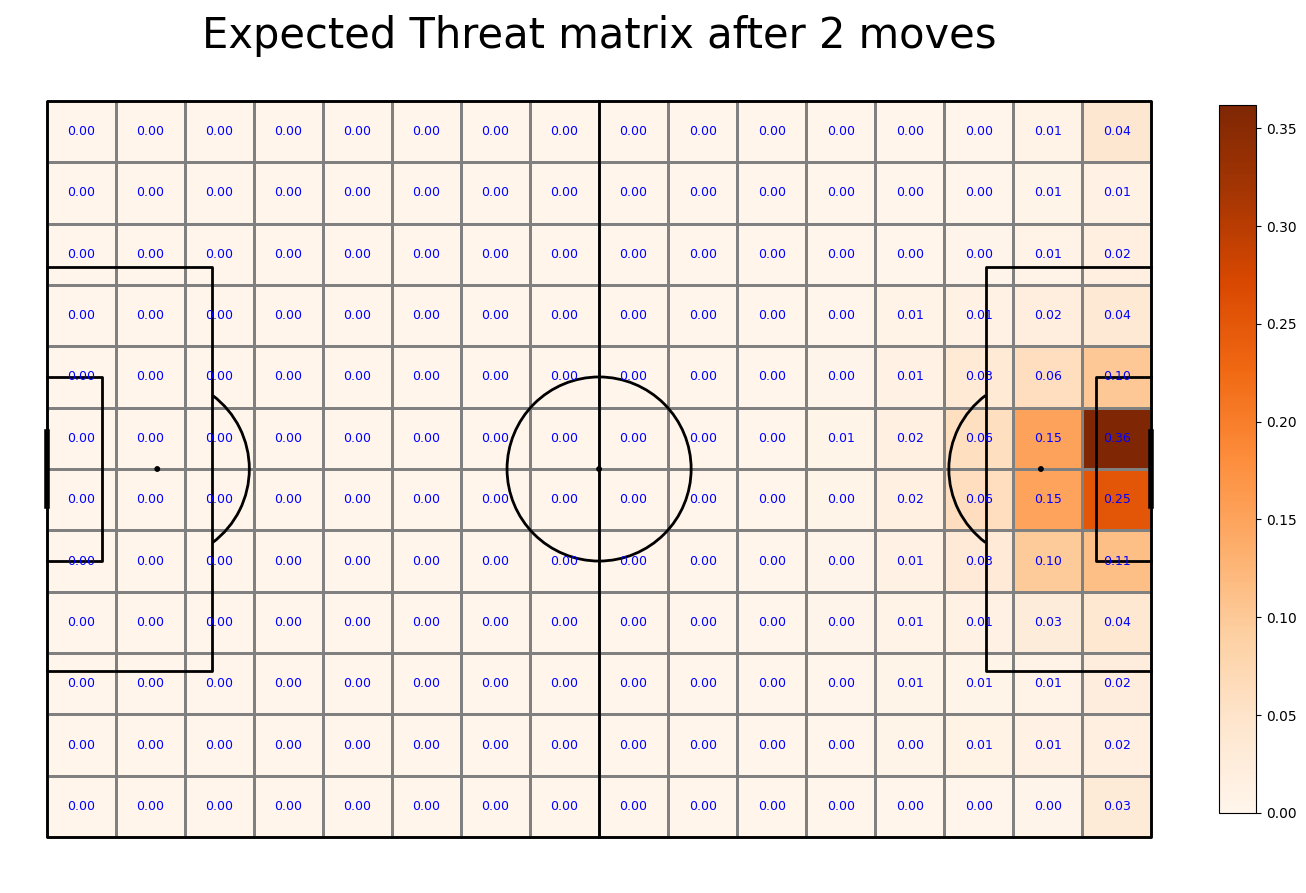

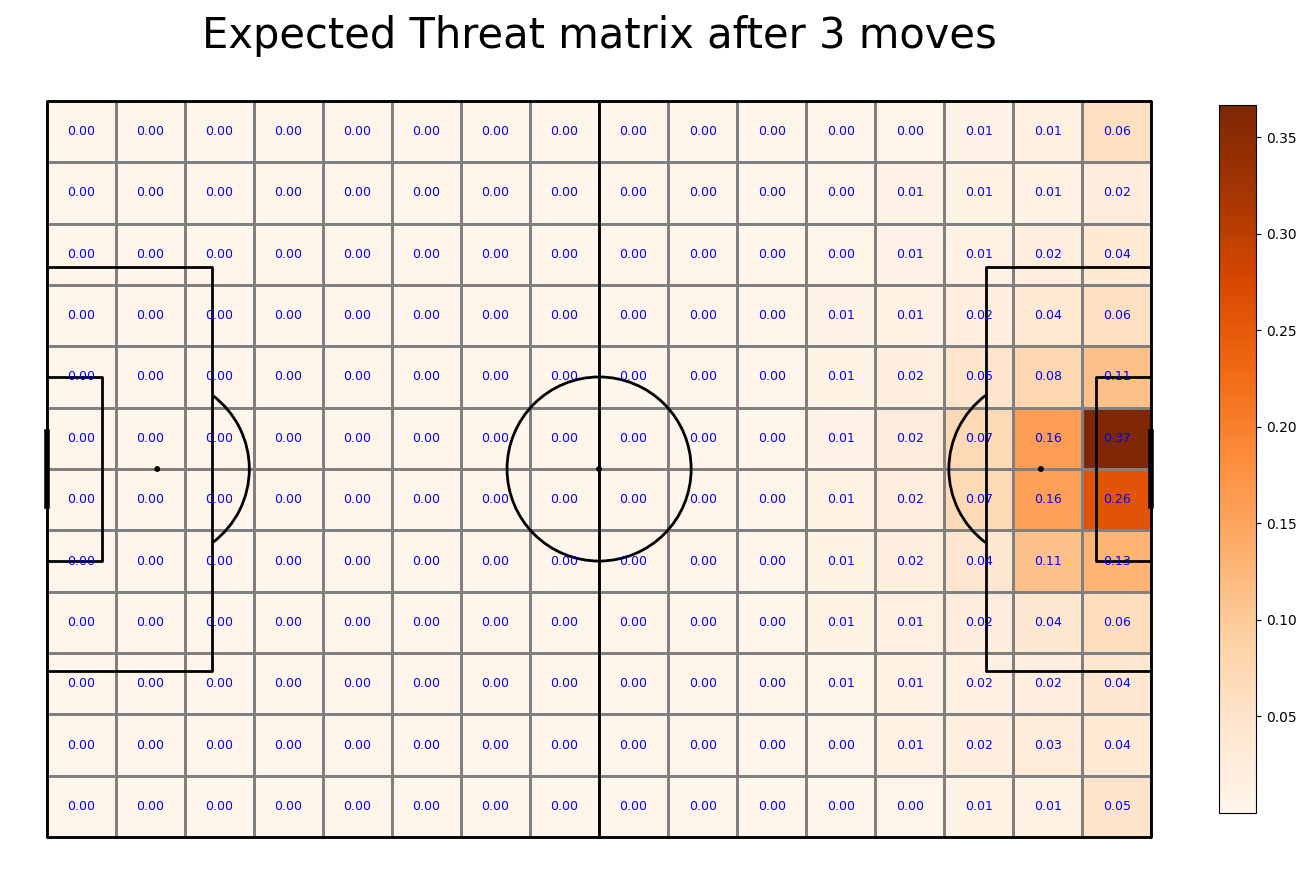

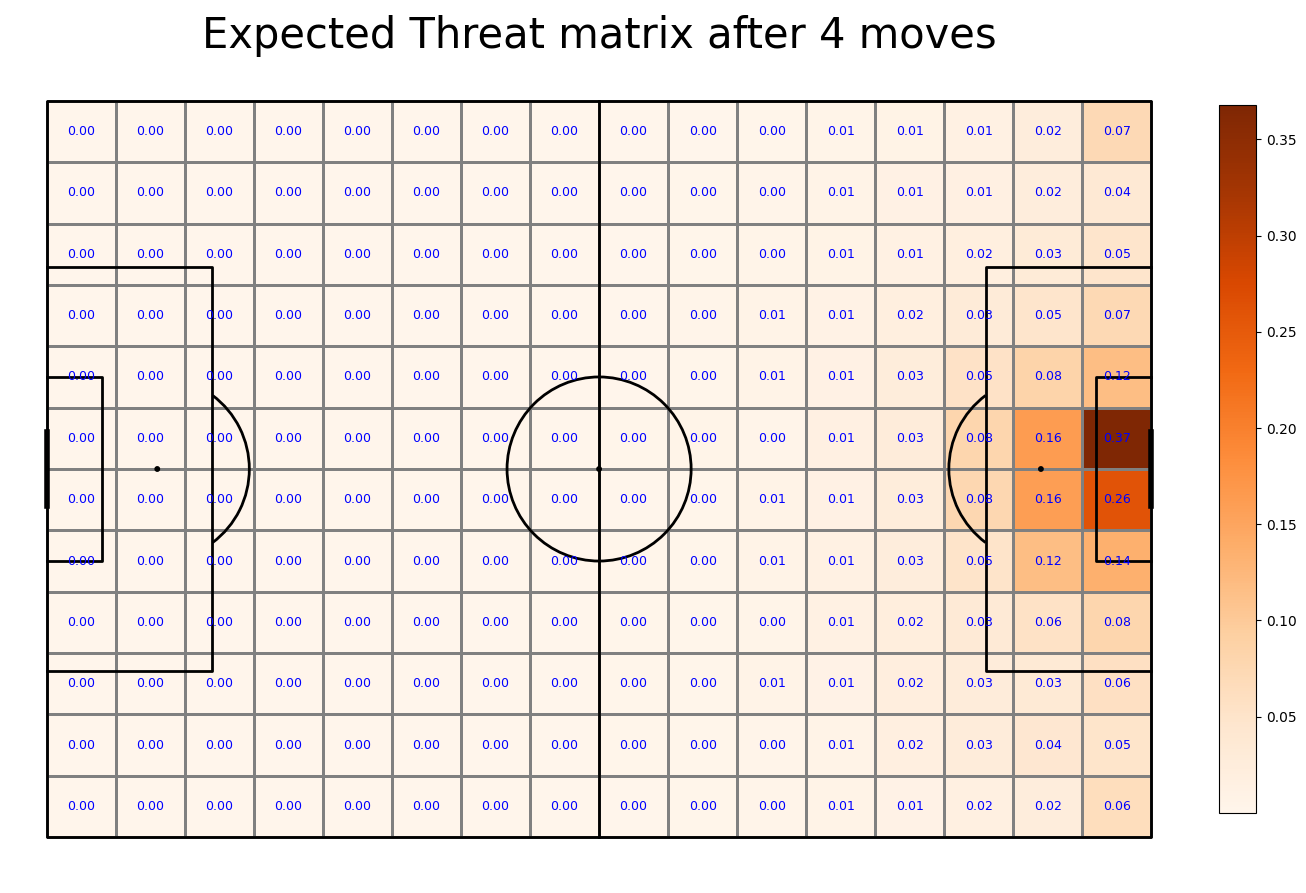

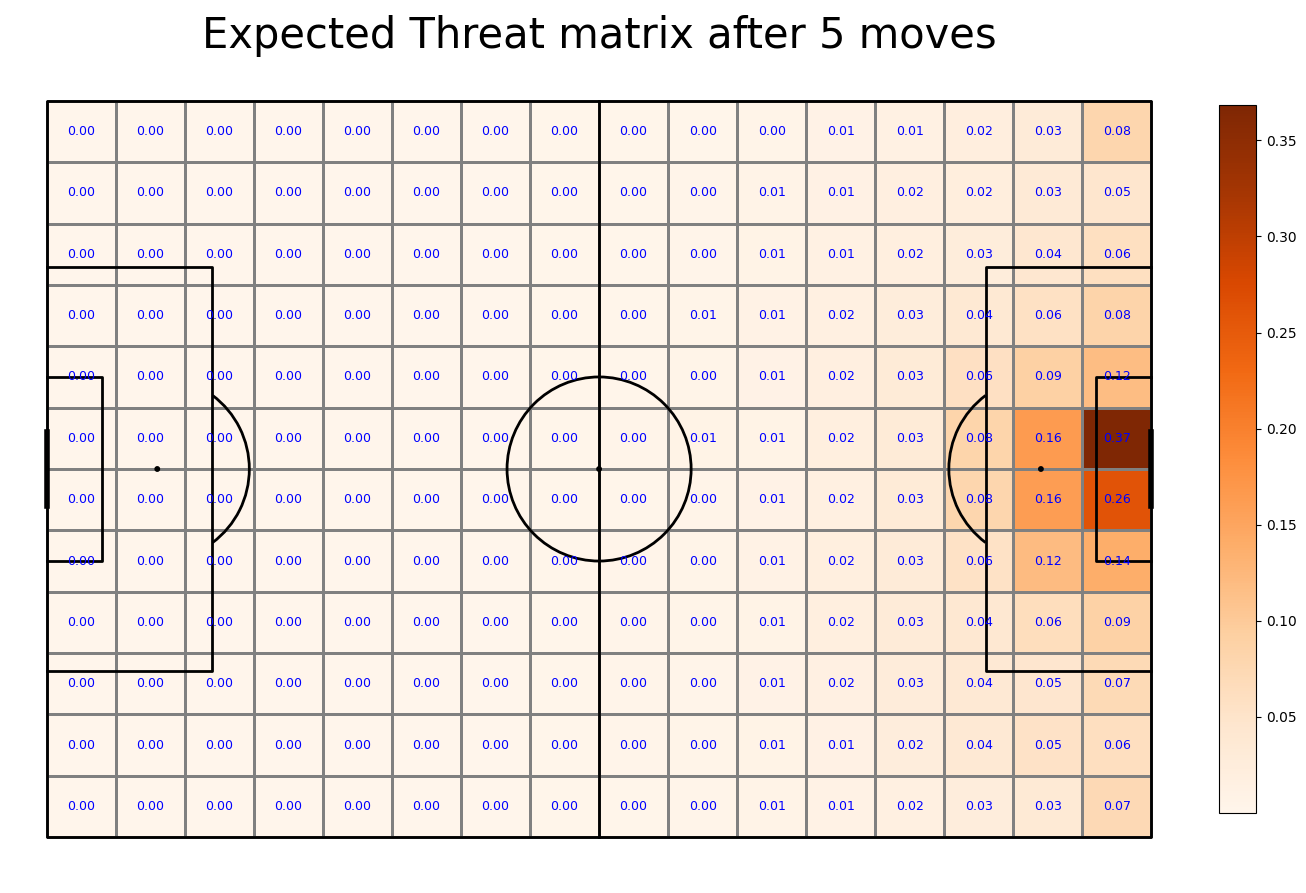

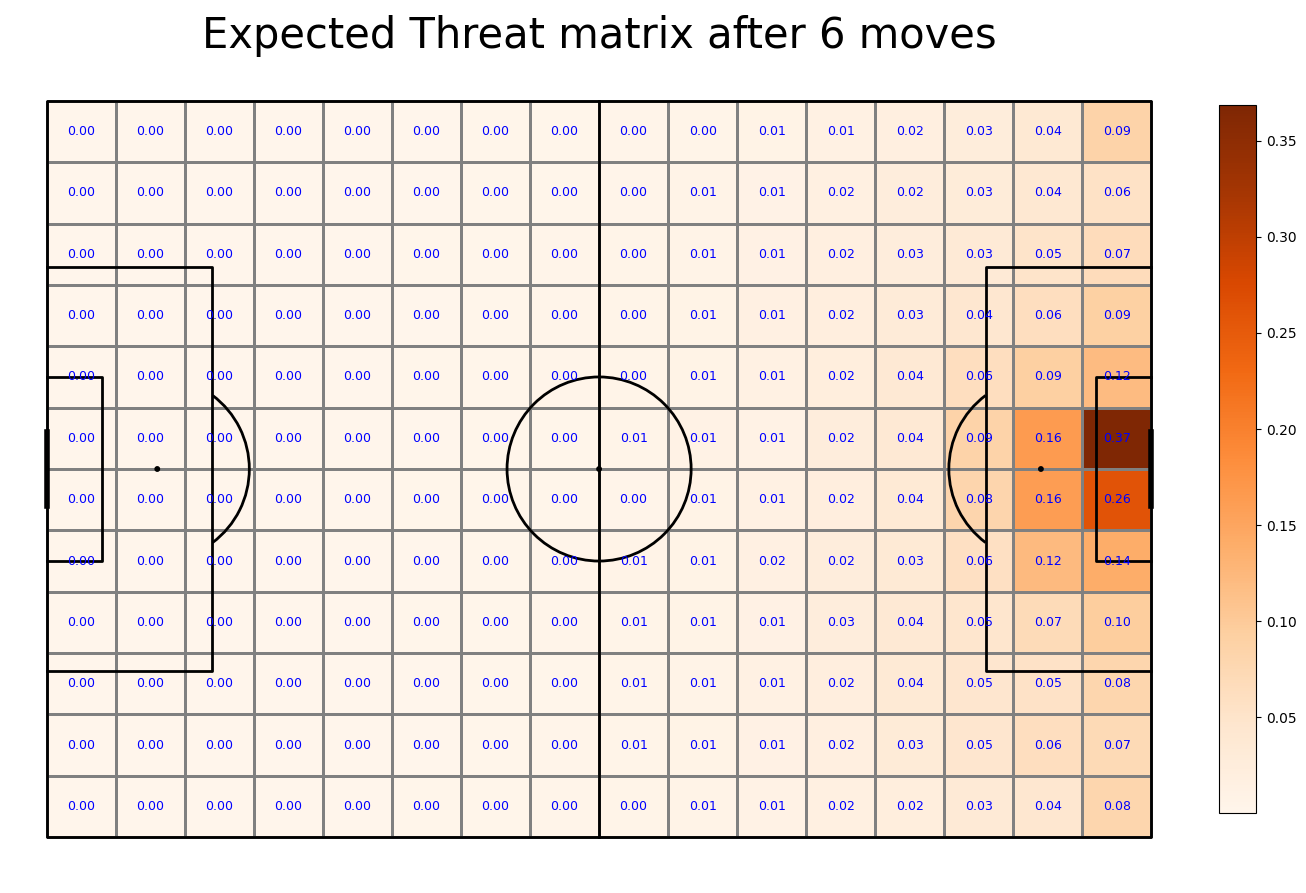

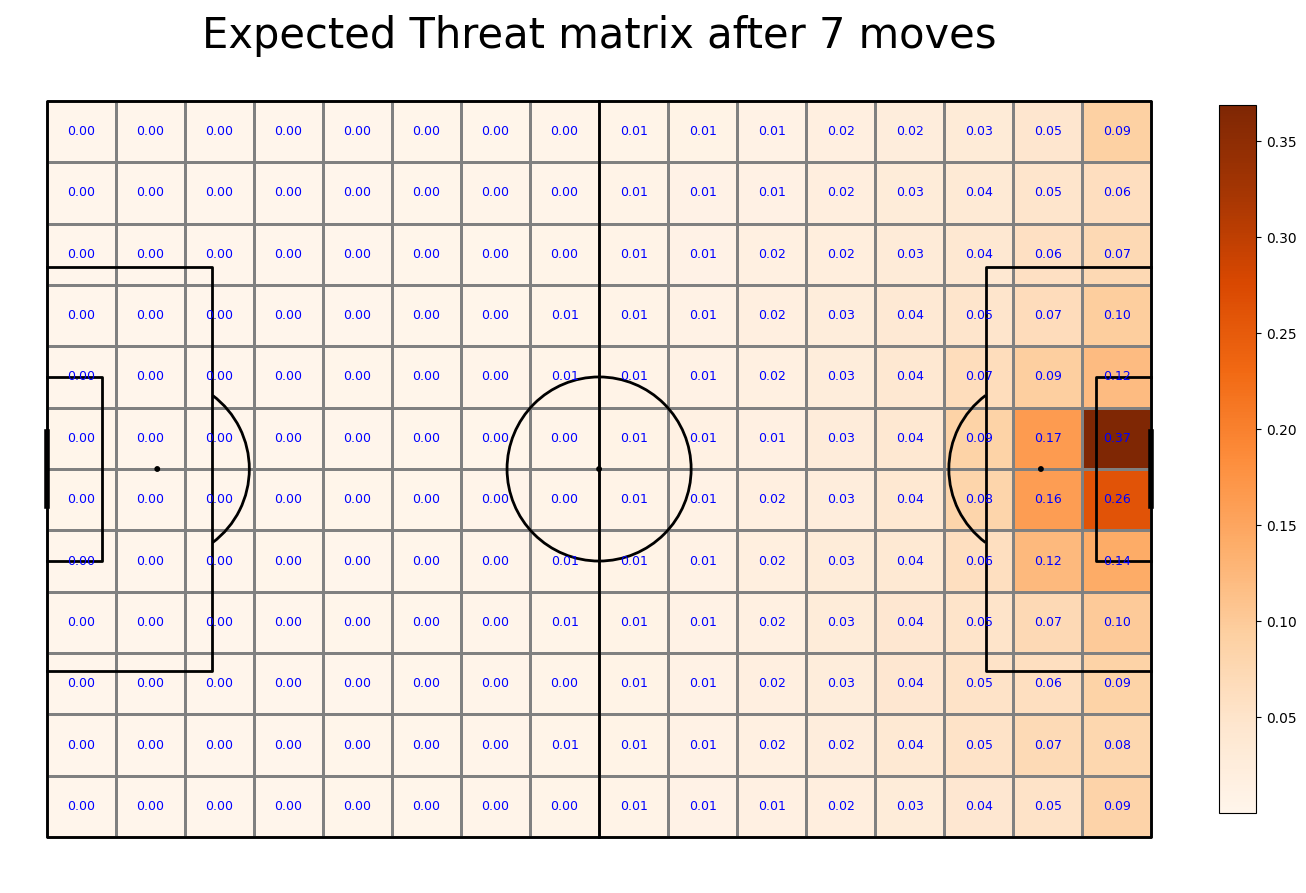

In [ ]:
transition_matrices_array = np.array(transition_matrices)

xT = np.zeros((12, 16))
for i in range(7):
    shoot_expected_payoff = shot_xg_grid*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

In [ ]:
transition_matrices

[array([[0.34615385, 0.03846154, 0.07692308, 0.03846154, 0.03846154,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.23076923, 0.03846154, 0.        , 0.03846154, 0.03846154,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.07692308, 0.        , 0.        , 0.        , 0.03846154,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.    